In [109]:
from time import time

import numpy as np
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision.datasets import  ImageFolder
from torchvision import transforms
from PIL import Image
import torchvision
import matplotlib.pyplot as plt 
from torch.optim import SGD
import torch.nn as nn 
# from scipy.signal import savgol_filter
import time as time
from sklearn.metrics import confusion_matrix

In [7]:
%matplotlib inline

In [8]:
"""
    2. LOADING AND NORMALIZING DATASET
"""

'\n    2. LOADING AND NORMALIZING DATASET\n'

In [10]:
def getStats(path):
    """
        Input:
        path --> Path to Image Folder

        Returns:
        avg --> mean of channels
        std --> stdDev of channels
        transform --> transform of images/tensors
    """
    # temporary ds to find mean and std
    tempDS = ImageFolder(path)

    # find avg and std in ds
    avg = [0,0,0]; std = [0,0,0]
    for pic in tempDS:
        # PIL needs pixel value b/w 0 and 1.
        img = np.asarray(pic[0])/255
        for i in range(3):
            avg[i] += (img[:,:,i].mean())/len(tempDS)
            std[i] += ((img[:,:,i]).std())/(len(tempDS))
    print(f'AVGS: {avg} \nSTDS: {std}')
    # transform each image to a tensor and normalize
    transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize(avg,std)]
)
    return avg,std,transform


In [11]:
"# My dataset values"
myAvg, myStd, transform = getStats(path="./letters")


AVGS: [0.6282307923169269, 0.5358974006269173, 0.4953553087901827] 
STDS: [0.18799243292129267, 0.20690560403400501, 0.20573593318662114]


In [12]:
"# create loader object for personal pictures"
trainSet = ImageFolder('./letters',transform=transform)
trainLoader = DataLoader(trainSet,batch_size=4,shuffle=True)
classes = ['A','B','C','D','E','F','G','H','I','K']

In [15]:
"# de-Normalize images (0,1) --> (0,255)"
def helpShow(img):
    # unnormalize images
    for i in range(3):
        img[:,:,i] = img[:,:,i]*myStd[i] + myAvg[i]
    npImg = img.numpy()
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


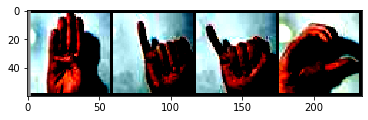

Letters:     B	    I	    I	    C


In [16]:
dataIter = iter(trainLoader)

images, labels = dataIter.next()

helpShow(torchvision.utils.make_grid(images))
print('Letters:','\t'.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
"""PART 3 BEGINS"""

"""MODEL FOR PERSONAL PCITURES"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=5,stride=1)

        self.pool = nn.MaxPool2d(2,2)
        # need to pad 1 pixel b/c dims become odd later

        self.poolE = nn.MaxPool2d(2,2,padding=1)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(12*12*8,32)
        self.fc2 = nn.Linear(32,18)
        self.fc3 = nn.Linear(18,10)



    
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.poolE(self.relu(self.conv2(x)))
        x = x.view(-1,12*12*8) 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = (self.fc3(x))
        return x


In [18]:
def loadModel(lr,loss=' '):

    torch.manual_seed(seed=0)
    model = CNN()
    optimizer = SGD(model.parameters(),lr)
    lossFxn = nn.MSELoss()
    if loss == 'ce':
        lossFxn = nn.CrossEntropyLoss()
    
    return model, optimizer, lossFxn

def loadData(batchSize):
    trainSet = ImageFolder('./letters',transform=transform)
    trainLoader = DataLoader(trainSet,batch_size=batchSize)

    return trainLoader


def tenToOneHot(argument):
    switcher = {
        0: [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
        1: [0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
        2: [0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
        3: [0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0],
        4: [0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0],
        5: [0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0],
        6: [0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0],
        7: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0],
        8: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0],
        9: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]}
       
    return (switcher[argument])

# Accuracy Function
def acc(pred,labels):
    numSamp = labels.size()[0]
    val, idx = torch.max(pred.data,1)
    correct = (idx == labels).sum().item()
    return correct/numSamp


In [21]:
"""TRAINING FUNCTION FOR MY OWN DATASET"""
def train(lr,batchSize,epochs,loss=None):
    model, optimizer, criterion = loadModel(lr=lr,loss=loss)
    data = loadData(batchSize=batchSize)
    trainAcc, trainLoss = [],[]

    tic = time.time()

    for epoch in range(epochs):

        runningAcc = 0; runningLoss = 0
        cnt = 0

        for idx, (inputs,labels) in enumerate(data,0):
            inputs, labels = inputs.float() , labels.float()

            # zero the gradients
            optimizer.zero_grad()
            # get predictions 
            outputs = model(inputs)
            # print(outputs)
            # create a label tensor that is the same size as the output
            labelsOneHot = torch.zeros([outputs.size()[0],outputs.size()[1]])
            for i in range(10):
                labelsOneHot[i,:] = torch.FloatTensor(
                    tenToOneHot(labels[i].item())
                )
            
            # compute loss
            loss = criterion(outputs.squeeze(),labelsOneHot)
            # optimize
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()
            runningAcc += acc(outputs,labels)
            cnt += 1

        trainLoss += [runningLoss/cnt]
        trainAcc += [runningAcc/cnt]
        if runningAcc/cnt == 1.0:
            print(f"100% accuracy achieved at epoch: {epoch}")

    print(trainAcc[-1])
    toc = time.time()
    totalTime = toc - tic

    print(f"Total Time: {totalTime} seconds.")

    fig,ax = plt.subplots(2,1,sharex=True)
    epochList = list(range(epochs))
    ax[0].plot(epochList,trainLoss,label='Training')
    ax[1].plot(epochList,trainAcc,label='Training Set')
    ax[0].set_ylabel('Loss'); ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch Num')
    plt.legend()
    plt.show()

   

In [22]:
batchSize = 10
lr = 0.1
epochs = 31

0.6333333333333333
Total Time: 1.2346739768981934 seconds.


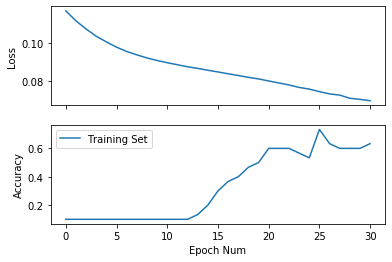

In [23]:
train(lr,batchSize,epochs)

In [24]:

"""STATISTICS FOR ENTIRE CLASS DATASET"""

cAvg,cStd,cTransform = getStats("./training_v2")

AVGS: [0.6876337871321516, 0.6189555937053737, 0.5673832596603504] 
STDS: [0.12917142914887608, 0.16189818592897234, 0.17227187253294954]


In [45]:
from model1 import CNN_4Conv
from model2 import CNN_2Conv

In [46]:



def classLoadData(batchSize,shuffle=True,seed=0,validSplit = 0.2):
    classTrain = ImageFolder("./training_v2",transform=cTransform)
    classSize = len(classTrain)
    classIdxs = list(range(classSize))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(classIdxs)
    split = int(np.floor(classSize*(1-validSplit)))
    trainIdxs, validIdxs = classIdxs[:split], classIdxs[split:]

    trainSampler = SubsetRandomSampler(trainIdxs)
    validSampler = SubsetRandomSampler(validIdxs)

    trainLoader = DataLoader(classTrain,batch_size=batchSize,sampler=trainSampler)
    validLoader = DataLoader(classTrain,batch_size=batchSize,sampler=validSampler)

    return trainLoader,validLoader



def classLoadModel(lr,numConv,batchNorm,outKernels,linDim,loss=None):
    torch.manual_seed(seed=0)
    if numConv == 4:
        model = CNN_4Conv(batchNorm=batchNorm,outKernels=outKernels,linDim=linDim)
    elif numConv == 2:
        model = CNN_2Conv(batchNorm=batchNorm,outKernels=outKernels,linDim=linDim)
    optimizer = SGD(model.parameters(),lr)
    if loss == 'ce':
        lossFxn = nn.CrossEntropyLoss()
    elif loss == 'mse':
        lossFxn = nn.MSELoss()
    
    return model, optimizer, lossFxn



def evalModel(model,validLoader,loss):

    if loss == 'ce':
        criterion = nn.CrossEntropyLoss()
    elif loss == 'mse':
        criterion = nn.MSELoss()

    runningValidAcc, runningValidLoss = 0,0
    cnt = 0
    for idx, (inputs,labels) in enumerate(validLoader):
        # print(f"    Validation Iteration: {cnt+1}")
        # ins and labs
        inputs = inputs.float(); 
        #outs
        outputs = model(inputs)
        # change labels to be same size as outputs
        if loss == 'mse':
            labelsOneHot = torch.zeros([outputs.size()[0],outputs.size()[1]])
            for i in range(labels.size()[0]):
                labelsOneHot[i,:] = torch.FloatTensor(
                    tenToOneHot(labels[i].item())
                )
            validLoss = criterion(outputs.squeeze(),labelsOneHot.float())
        elif loss == 'ce':
            validLoss = criterion(outputs.squeeze(),labels)
        # get loss
        
        runningValidLoss += validLoss.item()

        runningValidAcc += acc(outputs,labels)
        cnt += 1

    return runningValidLoss/cnt,runningValidAcc/cnt




In [123]:
# Training for entire class dataset

def classTV_Train(lr,batchSize,lossType,epochs,numConv,batchNorm,outKernels,linDim):
    model, optimizer, criterion = classLoadModel(lr=lr,loss=lossType,numConv=numConv,batchNorm=batchNorm,outKernels=outKernels,linDim=linDim)
    trainLoader, validLoader = classLoadData(batchSize=batchSize)

    trainAcc, validAcc, trainLoss, validLoss = [],[],[],[]

    tic = time.time()

    myPreds = []
    realPreds = []
    for epoch in range(epochs):
        epochTime = time.time() - tic

        print(f"At Epoch: {epoch}\nTime since start: {epochTime}")
        runningTrainAcc, runningTrainLoss = 0,0
        runningValidAcc, runningValidLoss = 0,0
        cnt = 0

        for idx, (inputs,labels) in enumerate(trainLoader):
            # print(f"    Training Iteration: {cnt+1}")
            # labels of shape 4x1
            inputs = inputs.float(); 
            
            # zero gradients
            optimizer.zero_grad()

            # get outputs of shape # bs x 10
            outputs = model(inputs)
            realPreds += labels.tolist()
            
            val,idx = torch.max(outputs.data,1)
            myPreds += idx.tolist()
            
            if lossType == 'mse':
                labelsOneHot = torch.zeros([outputs.size()[0],outputs.size()[1]])
                for i in range(labels.size()[0]):
                    labelsOneHot[i,:] = torch.FloatTensor(
                        tenToOneHot(labels[i].item())
                    )
                loss = criterion(outputs.squeeze(),labelsOneHot.float())
            
            


            elif lossType == 'ce':
                loss = criterion(outputs.squeeze(),labels)
            
            # compute loss
            
            # optimize
            loss.backward()
            optimizer.step()

            runningTrainLoss += loss.item()
            runningTrainAcc += acc(outputs,labels)
            cnt += 1
    

        batchValidLoss, batchValidAcc = evalModel(model,validLoader,loss=lossType)

        trainAcc += [runningTrainAcc/cnt]; trainLoss += [runningTrainLoss/cnt]
        validAcc += [batchValidAcc]; validLoss += [batchValidLoss]
        print(f"Train Accuracy at epoch {epoch}: {trainAcc[epoch]}")
        print(f"Valid Accuracy at epoch {epoch}: {validAcc[epoch]}")
        print(f"Train Loss at epoch {epoch}: {trainLoss[epoch]}")
        print(f"Valid Loss at epoch {epoch}: {validLoss[epoch]}\n")

    toc = time.time()
    print(f"Total Training Time: {(toc-tic)}")
    fig,ax = plt.subplots(2,1,sharex=True)
    axLoss = ax[0]; axAcc = ax[1]
    epochList = list(range(epochs))
    axLoss.plot(epochList,trainLoss,label='Training Set'); axLoss.plot(epochList,validLoss,label='Validation Set')
    axAcc.plot(epochList,trainAcc,label='Training Set'); axAcc.plot(epochList,validAcc,label='Validation Set')
    axLoss.set_ylabel('Loss'); axAcc.set_ylabel('Accuracy')
    axAcc.set_xlabel('Epoch Num (n)')
    plt.legend()


    C = (confusion_matrix(y_true=realPreds,y_pred=myPreds))
    classes = ['A','B','C','D','E','F','G','H','I','K']
    m = 0
    letters = []
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            else:
                if (C[i,j] + C[j,i]) > m:
                    m = (C[i,j]+C[j,i])
                    letters = [i,j]
    print(letters)
                


    return model
    
    

In [124]:
""" Hyperparameter Dicts"""
h1 = {"lr": 0.01, "batchSize": 4,"nnFirstLayer":32,"numConvLayer": 2,"numKernels":10}

h2 = {"lr": 0.1, "batchSize": 4,"nnFirstLayer":32,"numConvLayer": 2,"numKernels":10}

h3 = {"lr": 0.01, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 2,"numKernels":10}

h4 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 2,"numKernels":10}
# change model for h5, 30 kernels instead of 10...
h5 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 2,"numKernels":30}

## change model for below--> number of conv layers = 4
h6 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":8,"numConvLayer": 4,"numKernels":10}
# change model kernels
h7 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":8,"numConvLayer": 4,"numKernels":30}
# change model nnFirstlayer and kernels
h8 = {"lr": 0.01, "batchSize": 4,"nnFirstLayer":32,"numConvLayer": 4,"numKernels":10}

h9 = {"lr": 0.1, "batchSize": 4,"nnFirstLayer":32,"numConvLayer": 4,"numKernels":10}

h10 = {"lr": 0.01, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 4,"numKernels":10}

h11 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 4,"numKernels":10}
# change model kernels
h12 = {"lr": 0.1, "batchSize": 32,"nnFirstLayer":32,"numConvLayer": 4,"numKernels":30}

if (h1 != h2 != h3 != h4 != h5 != h6 != h7 != h8 != h9 != h10 != h11 != h12):
    print(True)       


True


In [125]:
## h1
classModel = classTV_Train(lr=0.01,batchSize=4,lossType='ce',epochs=22,numConv=4,batchNorm=False,outKernels=30,linDim=32)

At Epoch: 0
Time since start: 0.0
Train Accuracy at epoch 0: 0.10517693315858453
Valid Accuracy at epoch 0: 0.10602094240837696
Train Loss at epoch 0: 2.304116530937105
Valid Loss at epoch 0: 2.296264010574181

At Epoch: 1
Time since start: 13.498900651931763
Train Accuracy at epoch 1: 0.11762778505897772
Valid Accuracy at epoch 1: 0.14267015706806283
Train Loss at epoch 1: 2.292137273485976
Valid Loss at epoch 1: 2.271438245373871

At Epoch: 2
Time since start: 28.697295427322388
Train Accuracy at epoch 2: 0.30307994757536044
Valid Accuracy at epoch 2: 0.2683246073298429
Train Loss at epoch 2: 1.9173258869551113
Valid Loss at epoch 2: 2.309081588115992

At Epoch: 3
Time since start: 45.281917095184326
Train Accuracy at epoch 3: 0.5468545216251638
Valid Accuracy at epoch 3: 0.650087260034904
Train Loss at epoch 3: 1.2624890474629433
Valid Loss at epoch 3: 1.0302403752560392

At Epoch: 4
Time since start: 61.841387033462524
Train Accuracy at epoch 4: 0.6890563564875491
Valid Accuracy at

KeyboardInterrupt: 

In [41]:
"""Part 6: Best"""
classTV_Train(lr=0.01,batchSize=4,lossType='ce',epochs=30,numConv=4,batchNorm=False,outKernels=30,linDim=32)

In [ ]:
"""Part 6: BestSmall"""
classTV_Train(lr=0.1,batchSize=4,lossType='mse',epochs=20,numConv=4,batchNorm=False,outKernels=10,linDim=32)

In [121]:
torch.save(classModel.state_dict(),"./MyBest.pt")

TypeError: list indices must be integers or slices, not tuple